In [1]:
# Libraries

import numpy
import os
import shutil

In [2]:
# Code

from src.cnn.dataset import GeneDataset
from src.cnn.models  import Zrimec2020r

from src.cnn import core    as cnn_core
from src.cnn import dataset as cnn_dataset
from src.cnn import model   as cnn_model
from src.cnn import plot    as cnn_plot
from src.cnn import util    as cnn_util
from src.io  import loader  as data_loader

# 1. Setup

In [3]:
# Setup some directory paths.

OUT_SUBFOLDER = 'nbp06-zrimec2020r'
RES_SUBFOLDER = ''

CWD = os.getcwd()
OUT = os.path.join(CWD, 'out')
RES = os.path.join(CWD, 'res')

OUT_PLOT  = os.path.join(OUT, 'plot',  OUT_SUBFOLDER)
OUT_MODEL = os.path.join(OUT, 'model', OUT_SUBFOLDER)
RES_PLANT = os.path.join(RES, 'plant', RES_SUBFOLDER)
RES_MODEL = os.path.join(RES, 'model', RES_SUBFOLDER)
RES_NBP04 = os.path.join(OUT, 'data', 'nbp04-feature')
RES_NBP05 = os.path.join(OUT, 'data', 'nbp05-target')

shutil.rmtree(OUT_PLOT,  ignore_errors = True)
shutil.rmtree(OUT_MODEL, ignore_errors = True)

os.makedirs(OUT_PLOT,  exist_ok = True)
os.makedirs(OUT_MODEL, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT}')
print(f' Resource Directory : {RES}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\out
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\res


In [4]:
# Device

DEVICE = cnn_core.get_device(only_cpu = False)

Graphic devices : 1
Selected device : cuda


In [5]:
# Load the input <gene> features

gene_sequences = data_loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'features-bp2150.fasta'),
	to_string = True
)

gene_frequency = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-frequency.npz')
)

gene_stability = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-stability.npz')
)

tpm_value = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-tpm-value.json'),
	to_numpy = True
)

tpm_level = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-tpm-level.json'),
	to_numpy = True
)

tpm_order = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-tpm-order.json')
)

# 2. Regression

In [6]:
# Define basic data parameters

config = {
	'random_seed' : 14071994,
	'batch_size'  : [64, 64, 64], # train, valid, eval
	'split_size'  : [60, 20, 20], # train, valid, eval
	'input' : {
		'channels' : 1,
		'height'   : 4,
		'width'    : 2150,
		'features' : 64
	},
	'output' : {
		'group0' : 'tissue',
		'group1' : 'tissue-mean',
		'values' : 8
	}
}

config['split_size'] = [x / 100 for x in config['split_size']]

In [7]:
# Lock random

cnn_core.lock_random(seed = config['random_seed'])

## 2.1 Data

In [8]:
# Get the correct output group

targets = {
	key : value[config['output']['group1']]
	for key, value in tpm_value.items()
}

In [9]:
# Create a <gene> dataset and split it into dataloaders

# expand_dims = None -> [batch_size, H, W]
# expand_dims =   -1 -> [batch_size, H, W]
# expand_dims =    0 -> [batch_size, 1, H, W]
# expand_dims =    1 -> [batch_size, H, 1, W]
# expand_dims =    2 -> [batch_size, H, W, 1]

dataloaders = GeneDataset(
	sequences   = gene_sequences,
	features    = gene_frequency,
	targets     = targets,
	expand_dims = None
).split_to_dataloader(
	split_size  = config['split_size'],
	batch_size  = config['batch_size'],
	random_seed = config['random_seed'],
	shuffle     = True,
	drop_last   = True
)

train_dataloader = dataloaders[0]
valid_dataloader = dataloaders[1]
test_dataloader  = dataloaders[2]

In [10]:
# Display the training dataloader item dimensions

cnn_dataset.show_dataloader(
	dataloader = train_dataloader,
	batch_size = config['batch_size'][0]
)

Dataloader  batch  size :     64
Dataloader  batch count :    297
Dataloader sample count : 19,008

     Key shape : (64,)
Sequence shape : torch.Size([64, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 8])


In [11]:
# Display the validation dataloader item dimensions

cnn_dataset.show_dataloader(
	dataloader = valid_dataloader,
	batch_size = config['batch_size'][1]
)

Dataloader  batch  size :     64
Dataloader  batch count :     99
Dataloader sample count :  6,336

     Key shape : (64,)
Sequence shape : torch.Size([64, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 8])


In [12]:
# Display the testing dataloader item dimensions

cnn_dataset.show_dataloader(
	dataloader = test_dataloader,
	batch_size = config['batch_size'][2]
)

Dataloader  batch  size :     64
Dataloader  batch count :     99
Dataloader sample count :  6,336

     Key shape : (64,)
Sequence shape : torch.Size([64, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 8])


## 2.2 Model

In [13]:
# Create and display the model structure

model = Zrimec2020r(params = {
	'other' : {
		'in_height'   : config['input']['height'],
		'in_width'    : config['input']['width'],
		'in_features' : config['input']['features'],
		'dropout'     : 0.25
	},
	'conv1' : {
		'filters' : 32,
		'kernel'  : 3,
		'padding' : 0
	},
	'conv2' : {
		'filters' : 64,
		'kernel'  : 9,
		'padding' : 4
	},
	'conv3' : {
		'filters' : 128,
		'kernel'  : 9,
		'padding' : 4
	},
	'maxpool1' : {
		'kernel'  : 3,
		'padding' : 1
	},
	'maxpool2' : {
		'kernel'  : 3,
		'padding' : 1
	},
	'maxpool3' : {
		'kernel'  : 3,
		'padding' : 1
	},
	'fc1' : {
		'features' : 128
	},
	'fc2' : {
		'features' : config['output']['values']
	}
})

model.summary(
	batch_size  = config['batch_size'][0],
	in_height   = config['input']['height'],
	in_width    = config['input']['width'],
	in_features = config['input']['features'],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Zrimec2020r                              [64, 4, 2150]             [64, 8]                   --
├─Zrimec2020: 1-1                        [64, 4, 2150]             [64, 128]                 --
│    └─Conv1d: 2-1                       [64, 4, 2150]             [64, 32, 2148]            416
│    └─ReLU: 2-2                         [64, 32, 2148]            [64, 32, 2148]            --
│    └─BatchNorm1d: 2-3                  [64, 32, 2148]            [64, 32, 2148]            64
│    └─Dropout: 2-4                      [64, 32, 2148]            [64, 32, 2148]            --
│    └─MaxPool1d: 2-5                    [64, 32, 2148]            [64, 32, 430]             --
│    └─Conv1d: 2-6                       [64, 32, 430]             [64, 64, 430]             18,496
│    └─ReLU: 2-7                         [64, 64, 430]             [64, 64, 430]             --
│    └─BatchNorm1d: 2-8       

In [14]:
# Convert the model to double and initialize weights and biases

model = model.double()
model = model.apply(cnn_model.he_uniform_weight)
model = model.apply(cnn_model.zero_bias)

In [15]:
# Set the training parameters

criterion = cnn_model.get_criterion(
	query     = 'mse',
	reduction = 'mean'
)

optimizer = cnn_model.get_optimizer(
	query        = 'adam',
	model        = model,
	lr           = 1e-4,
	betas        = (0.900, 0.999),
	weight_decay = 0.05
)

scheduler = cnn_model.get_scheduler(
	query     = 'plateau',
	mode      = 'min',
	optimizer = optimizer,
	patience  = 2,
	factor    = 0.5,
	min_lr    = 1e-7
)

params = {
	'model'     : model,
	'savebest'  : os.path.join(OUT_MODEL, f'{model.__name__}-best.pth'), # None if should not save
	'savelast'  : os.path.join(OUT_MODEL, f'{model.__name__}-last.pth'), # None if should not save
	'epochs'    : 100,
	'criterion' : criterion,
	'optimizer' : optimizer,
	'scheduler' : scheduler,
	'device'    : DEVICE,
	'verbose'   : False,
	'train_dataloader' : train_dataloader,
	'valid_dataloader' : valid_dataloader,
	'test_dataloader'  : test_dataloader,
	'metrics' : {
		key : cnn_model.get_criterion(query = key, reduction = 'none')
		for key in ['mse', 'mae', 'huber', 'r2']
	}
}

## 2.3 Training

In [16]:
# Train and validate the model

report = cnn_model.train_regressor(
	model  = model,
	params = params
)

In [17]:
# Display the training and validation loss per epoch

epochs = len(report['train']['loss'])

for epoch in range(epochs) :
	print(f'Epoch {(1 + epoch):03d} :', end = ' ')
	print('{:10.5f}'.format(report['train']['loss'][epoch]), end = ' ')
	print('{:10.5f}'.format(report['valid']['loss'][epoch]))

Epoch 001 :    0.11738    0.09858
Epoch 002 :    0.09909    0.09722
Epoch 003 :    0.05704    0.04843
Epoch 004 :    0.02828    0.04737
Epoch 005 :    0.02521    0.03697
Epoch 006 :    0.02393    0.03701
Epoch 007 :    0.02275    0.04191
Epoch 008 :    0.02214    0.03553
Epoch 009 :    0.02164    0.03759
Epoch 010 :    0.02136    0.04004
Epoch 011 :    0.02124    0.02906
Epoch 012 :    0.02110    0.02873
Epoch 013 :    0.02098    0.03013
Epoch 014 :    0.02094    0.02761
Epoch 015 :    0.02082    0.02927
Epoch 016 :    0.02095    0.02675
Epoch 017 :    0.02095    0.03145
Epoch 018 :    0.02103    0.03515
Epoch 019 :    0.02089    0.04152
Epoch 020 :    0.02023    0.02418
Epoch 021 :    0.02006    0.02420
Epoch 022 :    0.01994    0.02458
Epoch 023 :    0.01985    0.02529
Epoch 024 :    0.01940    0.02553
Epoch 025 :    0.01905    0.02075
Epoch 026 :    0.01899    0.02254
Epoch 027 :    0.01890    0.02235
Epoch 028 :    0.01876    0.02098
Epoch 029 :    0.01824    0.02214
Epoch 030 :   

### 2.3.1 Plots

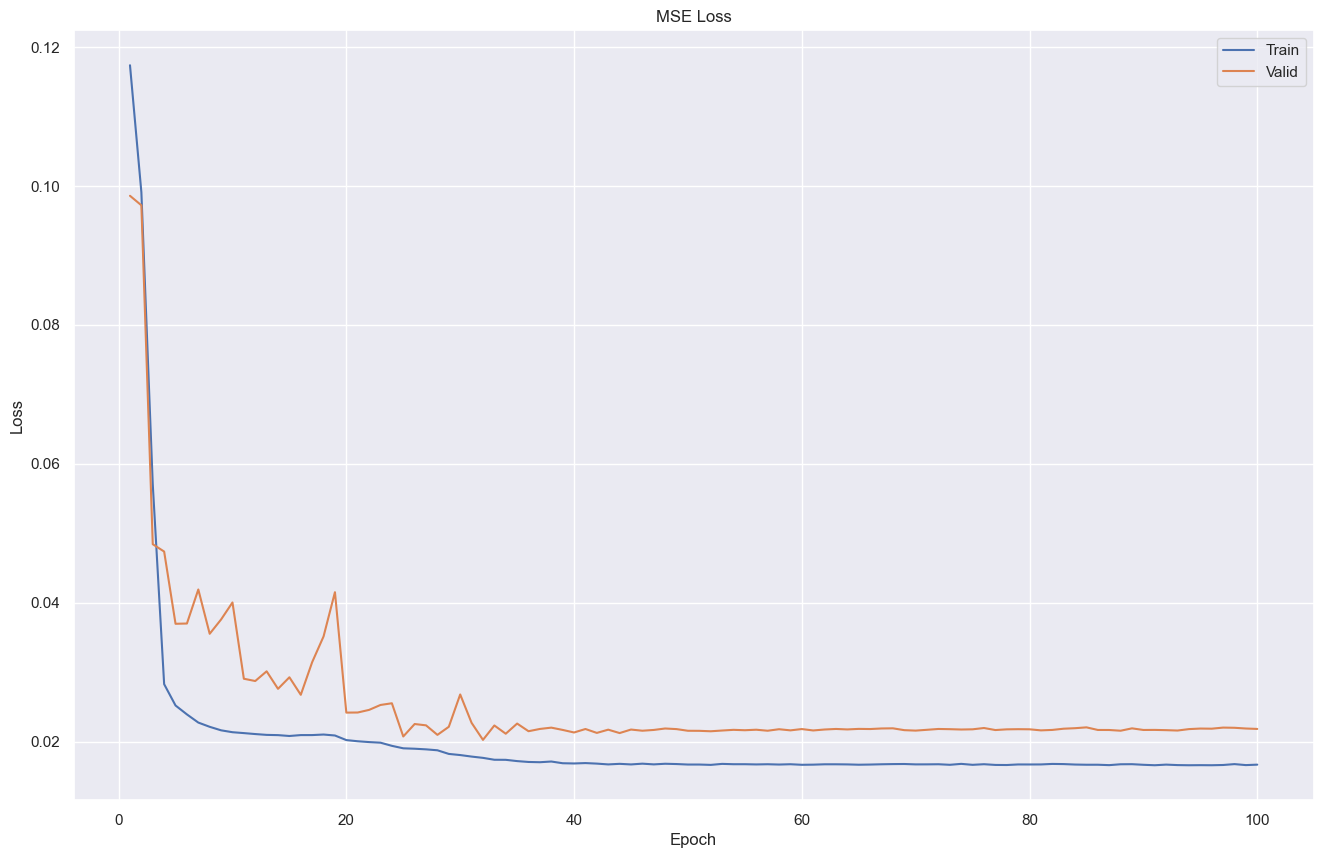

In [18]:
# Display the training and validation loss curves

cnn_plot.show_loss(
	report   = report,
	title    = 'MSE Loss',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

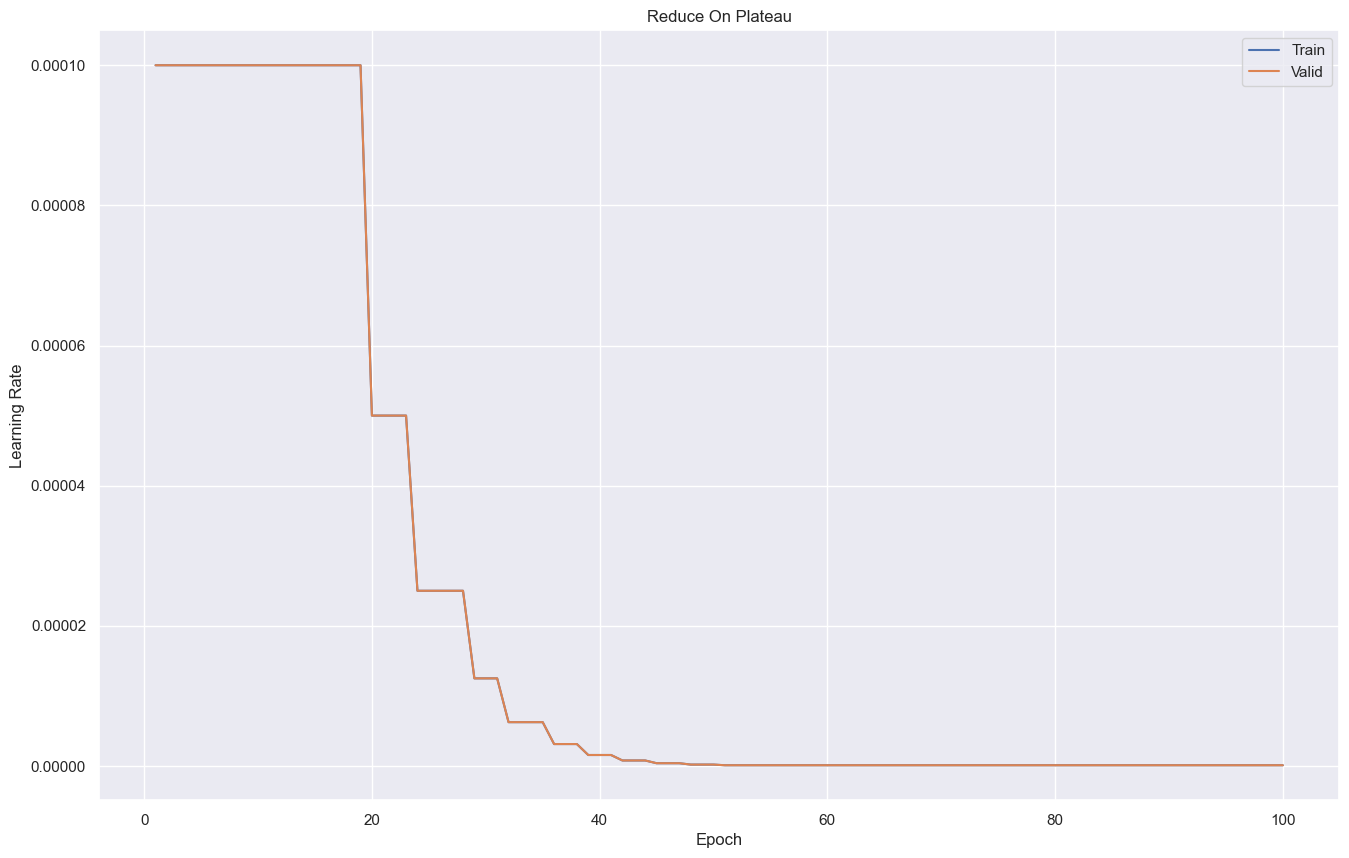

In [19]:
# Display the training and validation learning rate curves

cnn_plot.show_lr(
	report   = report,
	title    = 'Reduce On Plateau',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

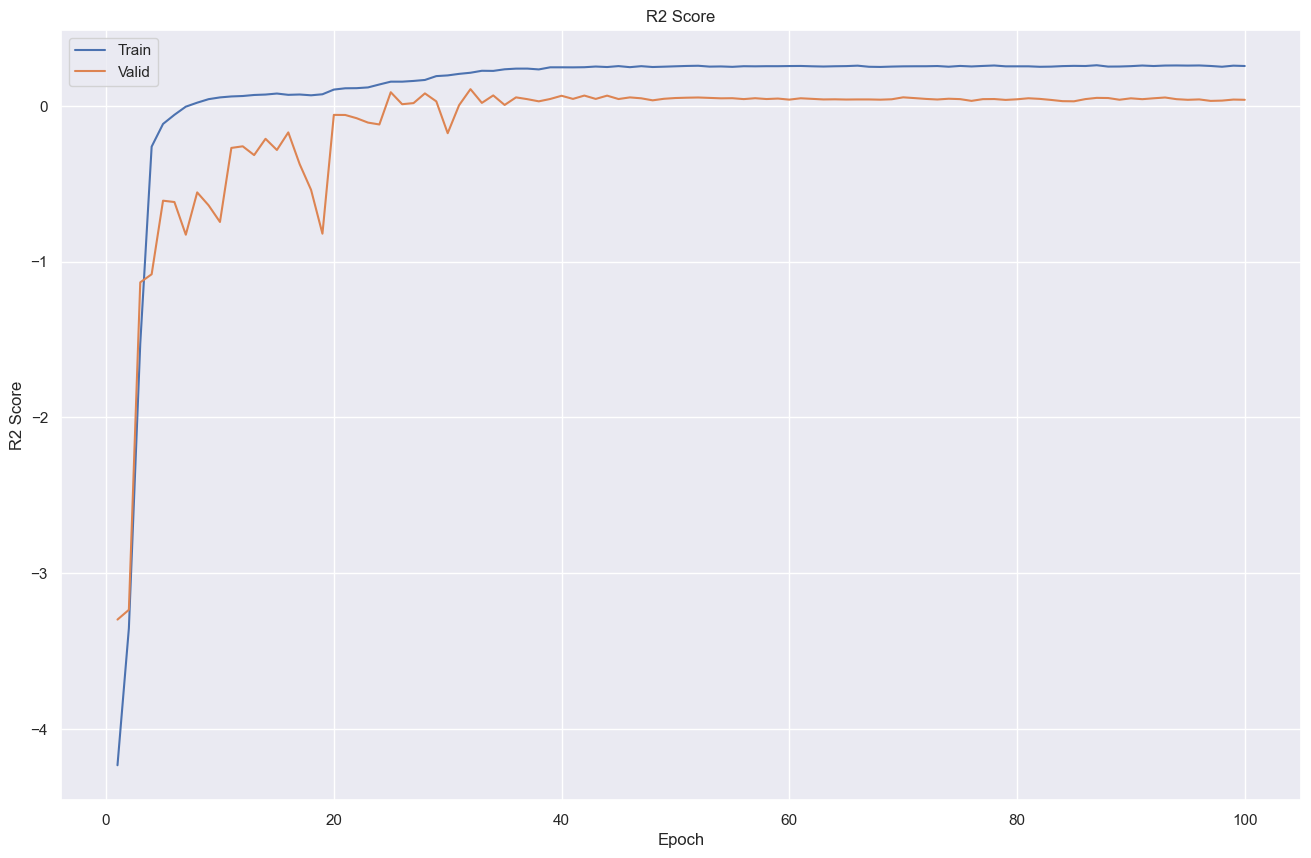

In [20]:
# Display the training and validation r2 score curves

cnn_plot.show_r2(
	report   = report,
	title    = 'R2 Score',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

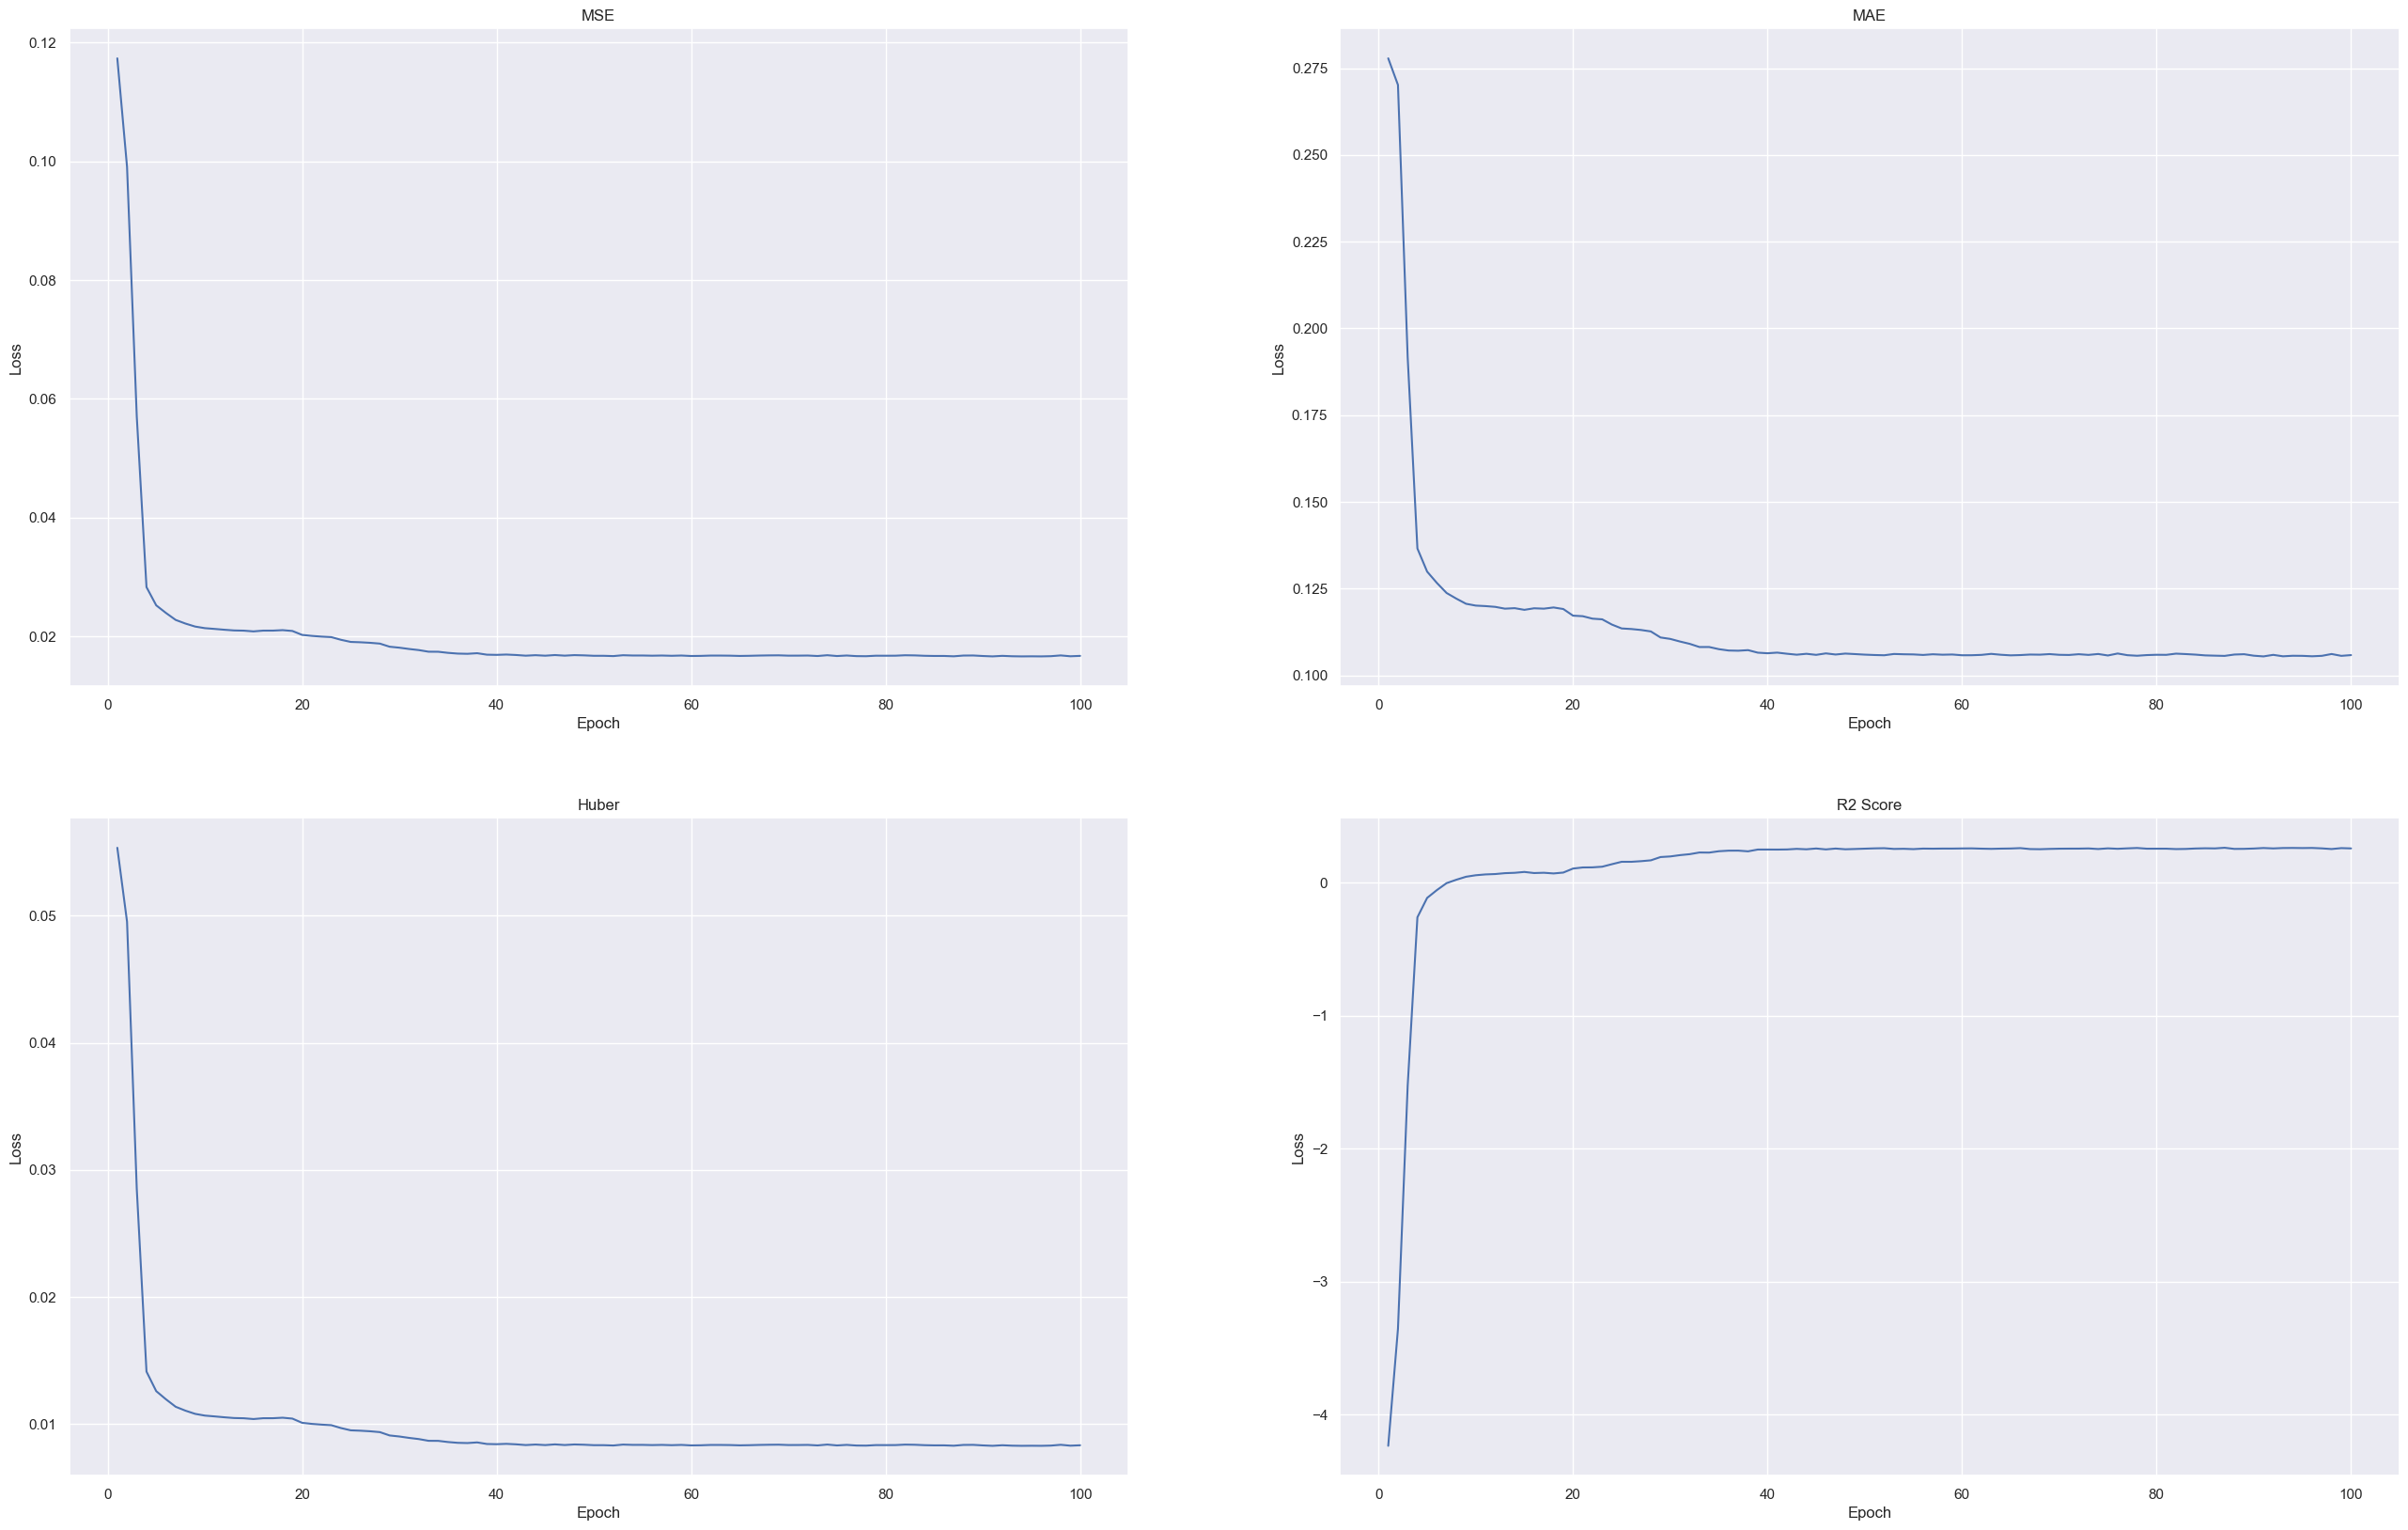

In [21]:
# Display the training metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'train',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-train')
)

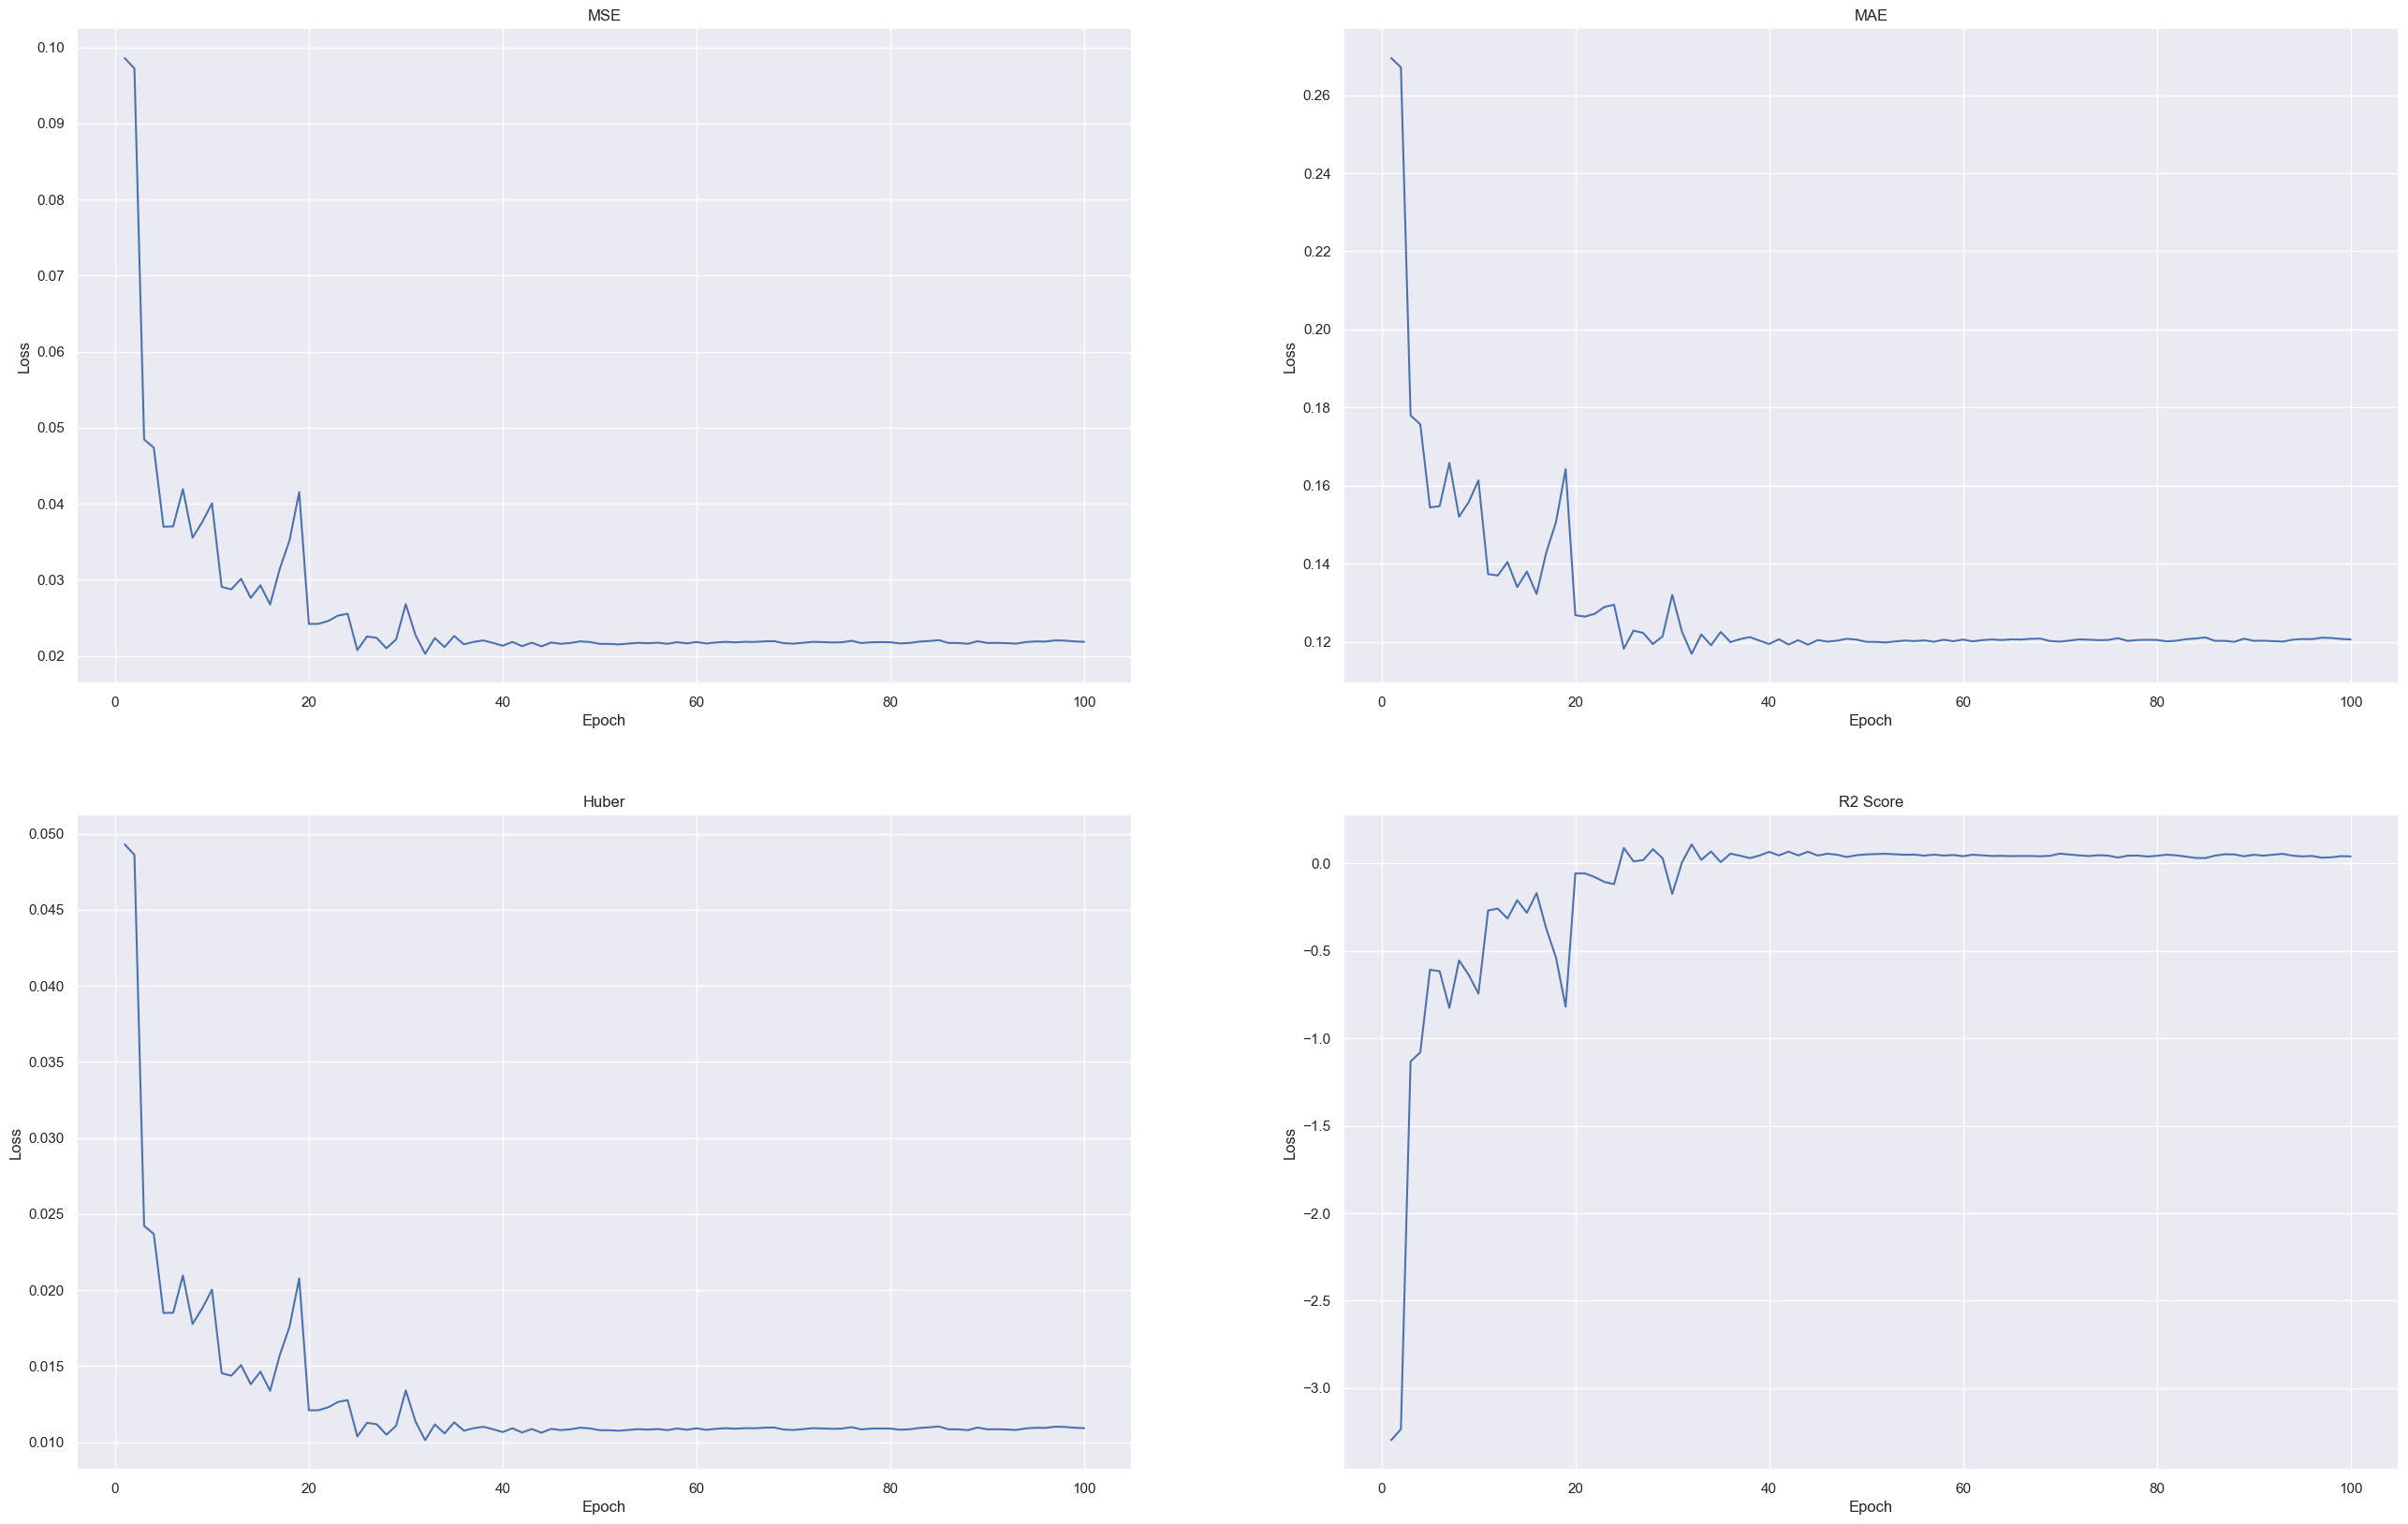

In [22]:
# Display the validation metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'valid',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-valid')
)

## 2.4 Evaluation

### 2.4.1 Last Model

In [23]:
# Load last model

checkpoint = data_loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-last.pth')
)

print('Epoch : ' + '{}'.format(checkpoint['epoch']))
print(' Loss : ' + '{:.5f}'.format(checkpoint['loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 100
 Loss : 0.02183


<All keys matched successfully>

In [24]:
# Evaluate the full model

report = cnn_model.eval_regressor(
	model  = model,
	params = params
)

In [25]:
# Print the evaluation metrics

print('R2 Score : ' + '{: 8.5f}'.format(report['eval']['metric']['r2'].mean()))
print('MAE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mae'].mean()))
print('MSE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mse'].mean()))

R2 Score :  0.04627
MAE Loss :  0.12034
MSE Loss :  0.02175


In [26]:
# Display the first few evaluation item predictions and expectations

cnn_util.display_regression_predictions(report = report, n = 2)

Gene : AT4G19140.1
True : [0.44581   0.42098   0.39282   0.47356   0.45811   0.44542   0.32232   0.28608]
Pred : [0.24452   0.19663   0.20045   0.22651   0.21282   0.22011   0.16239   0.11868]
 MAE : [0.20129   0.22435   0.19237   0.24705   0.24528   0.22531   0.15993   0.16740]
 MSE : [0.04052   0.05033   0.03701   0.06104   0.06016   0.05077   0.02558   0.02802]

Gene : AT4G15920.1
True : [0.52331   0.44289   0.43101   0.52655   0.24712   0.48275   0.42073   0.13099]
Pred : [0.31680   0.25919   0.26048   0.29545   0.27978   0.28756   0.21335   0.15706]
 MAE : [0.20650   0.18370   0.17052   0.23110   0.03266   0.19519   0.20738   0.02606]
 MSE : [0.04264   0.03375   0.02908   0.05341   0.00107   0.03810   0.04301   0.00068]



In [27]:
# Display the evaluation accuracy, as well as the amount of over and under predictions

dataframe = cnn_util.display_regression_accuracy(
	report    = report['eval'],
	order     = tpm_order[config['output']['group0']],
	threshold = {
		key : value[config['output']['group0'] + '-std']
		for key, value in tpm_value.items()
	}
).sort_values('Accuracy', ascending = False)

print('Accuracy : {:6.2f} %'.format(dataframe['Accuracy'].mean()))
print()

dataframe

Accuracy :  48.03 %



,Group,Total,Count,Accuracy,Avg MAE,Std MAE
7,senescence_reproductive,6336,4279,67.53,0.09,0.07
6,senescence_green,6336,4173,65.86,0.12,0.08
2,other,6336,3577,56.46,0.11,0.08
4,seed,6336,2947,46.51,0.12,0.08
1,leaf,6336,2556,40.34,0.13,0.09
5,seedling,6336,2507,39.57,0.13,0.09
3,root,6336,2348,37.06,0.13,0.09
0,flower,6336,1959,30.92,0.13,0.09


### 2.4.2 Best Model

In [28]:
# Load best model

checkpoint = data_loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-best.pth')
)

print('Epoch : ' + '{}'.format(checkpoint['epoch']))
print(' Loss : ' + '{:.5f}'.format(checkpoint['loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 32
 Loss : 0.02026


<All keys matched successfully>

In [29]:
# Evaluate the full model

report = cnn_model.eval_regressor(
	model  = model,
	params = params
)

In [30]:
# Print the evaluation metrics

print('R2 Score : ' + '{: 8.5f}'.format(report['eval']['metric']['r2'].mean()))
print('MAE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mae'].mean()))
print('MSE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mse'].mean()))

R2 Score :  0.11373
MAE Loss :  0.11616
MSE Loss :  0.02012


In [31]:
# Display the first few evaluation item predictions and expectations

cnn_util.display_regression_predictions(report = report, n = 2)

Gene : AT4G22120.4
True : [0.38187   0.14004   0.26777   0.32626   0.29058   0.22318   0.04829   0.14595]
Pred : [0.31395   0.25586   0.25794   0.29281   0.27671   0.28420   0.21067   0.15592]
 MAE : [0.06792   0.11582   0.00982   0.03345   0.01386   0.06102   0.16238   0.00997]
 MSE : [0.00461   0.01341   0.00010   0.00112   0.00019   0.00372   0.02637   0.00010]

Gene : AT3G25910.1
True : [0.56414   0.51843   0.46529   0.55857   0.55543   0.54028   0.45533   0.40658]
Pred : [0.34536   0.28285   0.28396   0.32277   0.30570   0.31336   0.23265   0.17261]
 MAE : [0.21878   0.23559   0.18133   0.23579   0.24973   0.22692   0.22267   0.23397]
 MSE : [0.04786   0.05550   0.03288   0.05560   0.06236   0.05149   0.04958   0.05474]



In [32]:
# Display the evaluation accuracy, as well as the amount of over and under predictions

dataframe = cnn_util.display_regression_accuracy(
	report    = report['eval'],
	order     = tpm_order[config['output']['group0']],
	threshold = {
		key : value[config['output']['group0'] + '-std']
		for key, value in tpm_value.items()
	}
).sort_values('Accuracy', ascending = False)

print('Accuracy : {:6.2f} %'.format(dataframe['Accuracy'].mean()))
print()

dataframe

Accuracy :  48.49 %



,Group,Total,Count,Accuracy,Avg MAE,Std MAE
7,senescence_reproductive,6336,4250,67.08,0.09,0.06
6,senescence_green,6336,4179,65.96,0.11,0.08
2,other,6336,3708,58.52,0.11,0.08
4,seed,6336,2982,47.06,0.12,0.08
1,leaf,6336,2574,40.62,0.13,0.09
5,seedling,6336,2522,39.80,0.12,0.08
3,root,6336,2380,37.56,0.13,0.09
0,flower,6336,1986,31.34,0.12,0.09


## 2.5 Visualization